# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.


#### Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём - указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from numpy.random import RandomState
state = RandomState(12345)
import matplotlib.pyplot as plt

g0 = pd.read_csv('/datasets/geo_data_0.csv')
g1 = pd.read_csv('/datasets/geo_data_1.csv')
g2 = pd.read_csv('/datasets/geo_data_2.csv')

g0 = g0.drop('id', axis=1)
g1 = g1.drop('id', axis=1)
g2 = g2.drop('id', axis=1)

print(g0.duplicated().sum())
print(g1.duplicated().sum())
print(g2.duplicated().sum())

g1 = g1.query('product > 0')

print(g0.info())
print(g1.info())
print(g2.info())
print(g0.head())
print(g1.head())
print(g2.head())

0
0
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91765 entries, 0 to 99999
Data columns (total 4 columns):
f0         91765 non-null float64
f1         91765 non-null float64
f2         91765 non-null float64
product    91765 non-null float64
dtypes: float64(4)
memory usage: 3.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB
None
         f0        f1        f2     product
0  0.705745 -0.497823  1.221170  105.280062
1  1.334711 -0.340164  4.3650

In [21]:
g11= g1['product'].drop_duplicates().count()
g11

11

Я проверила данные на пропуски, на дубликаты - вроде, всё в порядке. В гео1 были нулевые значения прибыли, эти месторождения я дропнула - такие месторождения нам не интересны. Столбец с id месторождений также не пригодится. 
Гео1 в целом, странный датасет - в нем встречаются только уникальных 11 значений product. Выглядит так, будто  это 11 категорий, под которые распределили все данные f0,f1,f2, и модель наверняка будет склонна к переобучению на таких данных. Придётся работать с таким датасетом - других вариантов нет. Сокращать датасет до 11 строк считаю нецелесообразным - тогда данных для обучения будет слишком мало.

# 2. Обучение и проверка модели

In [2]:
target0 = g0['product']
features0= g0.drop('product', axis=1)
target1 = g1['product']
features1= g1.drop('product', axis=1)
target2 = g2['product']
features2= g2.drop('product', axis=1)
numeric = ['f0', 'f1', 'f2']

features_train0, features_valid0, target_train0, target_valid0 = train_test_split(
   features0, target0, test_size=0.25, random_state=12345)
scaler = StandardScaler()
scaler.fit(features_train0[numeric])
features_train0[numeric] = scaler.transform(features_train0[numeric])
features_valid0[numeric] = scaler.transform(features_valid0[numeric])
model = LinearRegression()
model.fit(features_train0, target_train0)
predict0 = model.predict(features_valid0)
mse0 = mean_squared_error(target_valid0, predict0)
print("g0:")
print("RMSE =", mse0 ** 0.5)
print("mean =", predict0.mean())
print("R2 =", r2_score(target_valid0, predict0))

features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
   features1, target1, test_size=0.25, random_state=12345)
numeric = ['f0', 'f1', 'f2']
scaler.fit(features_train1[numeric])
features_train1[numeric] = scaler.transform(features_train1[numeric])
features_valid1[numeric] = scaler.transform(features_valid1[numeric])
model.fit(features_train1, target_train1)
predict1 = model.predict(features_valid1)
mse1 = mean_squared_error(target_valid1, predict1)
print("")
print("g1:")
print("RMSE =", mse1 ** 0.5)
print("mean =", predict1.mean())
print("R2 =", r2_score(target_valid1, predict1))

features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
   features2, target2, test_size=0.25, random_state=12345)
scaler.fit(features_train2[numeric])
features_train2[numeric] = scaler.transform(features_train2[numeric])
features_valid2[numeric] = scaler.transform(features_valid2[numeric])
model.fit(features_train2, target_train2)
predict2 = model.predict(features_valid2)
mse2 = mean_squared_error(target_valid2, predict2)
print("")
print("g2:")
print("RMSE =", mse2 ** 0.5)
print("mean =", predict2.mean())
print("R2 =", r2_score(target_valid2, predict2))

g0:
RMSE = 37.5794217150813
mean = 92.59256778438038
R2 = 0.27994321524487786

g1:
RMSE = 0.8856021667872856
mean = 74.92220858318946
R2 = 0.9995727386904206

g2:
RMSE = 40.02970873393434
mean = 94.96504596800489
R2 = 0.20524758386040443


Средний запас сырья больше всего в гео2, но в нем же и rmse хуже всего. Обучиться на гео1 было проще всего - поэтому такое отличное качестве при самом низком запасе сырья. Но есть опасение, что модель, обученная на гео1 будет хуже работать на данных типа гео0 и гео2, так как менее чувствительная к большому количеству значений.

In [3]:
#Объединяю предсказания и признаки в датасеты
all_predict0 = model.predict(features0)
all_predict1 = model.predict(features1)
all_predict2 = model.predict(features2)

features0 = features0.reset_index(drop=True)
features1 = features1.reset_index(drop=True)
features2 = features2.reset_index(drop=True)

predict0_df = pd.DataFrame([all_predict0]).T
predict1_df = pd.DataFrame([all_predict1]).T
predict2_df = pd.DataFrame([all_predict2]).T

predict0_df = features0.join(predict0_df)
predict1_df = features1.join(predict1_df)
predict2_df = features2.join(predict2_df)

predict0_df.set_axis(['f0', 'f1', 'f2', 'predictions'], axis = 'columns', inplace = True)
predict1_df.set_axis(['f0', 'f1', 'f2', 'predictions'], axis = 'columns', inplace = True)
predict2_df.set_axis(['f0', 'f1', 'f2', 'predictions'], axis = 'columns', inplace = True)
predict0_df

,f0,f1,f2,predictions
0,0.705745,-0.497823,1.221170,119.315661
1,1.334711,-0.340164,4.365080,181.649141
2,1.022732,0.151990,1.419926,123.224812
3,-0.032172,0.139033,2.978566,154.060925
4,1.988431,0.155413,4.751769,189.312273
...,...,...,...,...
99995,0.971957,0.370953,6.075346,215.475005
99996,1.392429,-0.382606,1.273912,120.389433
99997,1.029585,0.018787,-1.348308,68.369395
99998,0.998163,-0.528582,1.583869,126.522122


In [4]:
predict1_df

,f0,f1,f2,predictions
0,-15.001348,-8.276000,-0.005876,94.718393
1,14.272088,-3.475083,0.999183,115.858715
2,6.263187,-5.948386,5.001160,194.926717
3,-13.081196,-11.506057,4.999415,194.258595
4,12.702195,-8.147433,5.004363,195.494637
...,...,...,...,...
91760,9.535637,-6.878139,1.998296,135.653754
91761,-10.160631,-12.558096,5.005581,194.613561
91762,-7.378891,-3.084104,4.998651,193.938349
91763,0.665714,-6.152593,1.000146,115.342904


In [5]:
predict2_df

,f0,f1,f2,predictions
0,-1.146987,0.963328,-0.828965,78.477490
1,0.262778,0.269839,-2.530187,44.885688
2,0.194587,0.289035,-5.586433,-15.693094
3,2.236060,-0.553760,0.930038,113.631571
4,-0.515993,1.716266,5.899011,211.802858
...,...,...,...,...
99995,-1.777037,1.125220,6.263374,218.999691
99996,-1.261523,-0.894828,2.524545,145.071473
99997,-1.199934,-2.957637,5.219411,198.635648
99998,-2.419896,2.417221,-5.548444,-15.234559


# 3. Подготовка к расчёту прибыли

In [6]:
total_budget = 10000000000
one_well = 50000000
barrel_price = 4500

x= one_well / barrel_price #сколько должно быть минимально баррлей в одной скважине, чтобы окупить её разработку
y = total_budget / one_well #на разработку какого количества скважин хватает бюджета
z = (x * y) / 1000 #мнимальный объём сырья в регионе, достаточный для его разработки
print('Минимально необходимый объём сырья в регионе, тыс:',z)
print('Средний объём сырья в 200 скважинах в регионе geo0:',predict0.mean()* y)
print('Средний объём сырья в 200 скважинах в регионе geo1:',predict1.mean()* y)
print('Средний объём сырья в 200 скважинах в регионе geo2:',predict2.mean()* y)


Минимально необходимый объём сырья в регионе, тыс: 2222.2222222222226
Средний объём сырья в 200 скважинах в регионе geo0: 18518.513556876074
Средний объём сырья в 200 скважинах в регионе geo1: 14984.441716637892
Средний объём сырья в 200 скважинах в регионе geo2: 18993.009193600978


Как минимум 2223 тысячей баррелей должно быть в выбранных нами 200 месторождениях, чтобы окупить разработку, не говоря уже о прибыли. И, судя по средним, мы закрываем этот объём в любом из регионов.

In [7]:
# функция для расчёта прибыли по набору отобранных месторождений и предсказаний модели. 
# возвращает суммарную прибыль с count лучших месторождений из data

def profit_calc(data,count):
    calc = data['predictions'] * 4500
    calc_sorted = calc.sort_values(ascending=False)
    selected = calc_sorted[:count]
    return selected.sum()


# 4. Расчёт прибыли и рисков 

In [8]:
values0 = []
for i in range(1000):
    probs_subsample0 = predict0_df.sample(n = 500, replace=True, random_state=state)
    values0.append(profit_calc(probs_subsample0, 200))
values0 = pd.Series(values0)
lower0 = values0.quantile(0.05)
mean0 = values0.mean()
print("geo0:")
print("Средняя выручка:", mean0)
print("5%-квантиль:", lower0)

values1 = []
for i in range(1000):
    probs_subsample1 = predict1_df.sample(n = 500, replace=True, random_state=state)
    values1.append(profit_calc(probs_subsample1, 200))
values1 = pd.Series(values1)
lower1 = values1.quantile(0.05)
mean1 = values1.mean()
print("")
print("geo1:")
print("Средняя выручка:", mean1)
print("5%-квантиль:", lower1)

values2 = []
for i in range(1000):
    probs_subsample2 = predict2_df.sample(n = 500, replace=True, random_state=state)
    values2.append(profit_calc(probs_subsample2, 200))
values2 = pd.Series(values2)
lower2 = values2.quantile(0.05)
mean2 = values2.mean()
print("")
print("geo2:")
print("Средняя выручка:", mean2)
print("5%-квантиль:", lower2)

geo0:
Средняя выручка: 186304031.72061938
5%-квантиль: 180779352.8852299

geo1:
Средняя выручка: 163484684.8693482
5%-квантиль: 161114956.24780226

geo2:
Средняя выручка: 189966846.1580475
5%-квантиль: 184369206.87165952


Наибольшая средняя выручка у нас в гео2, но с вероятностью 95% мы получим немного меньше прибыли. Похожая ситуация и с гео0. С гео1 интереснее - разница между средней выручкой и 5-м квантилем у неё заметно меньше, чем у остальных регионов - потому что качество модели было лучше. Все три региона окупаются, но посмотрим на риски:

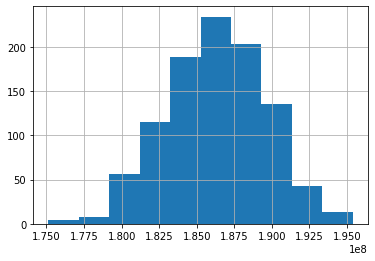

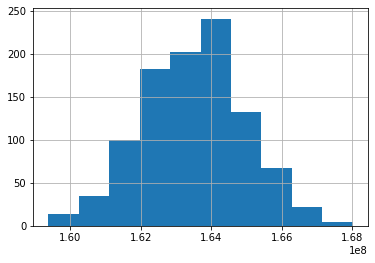

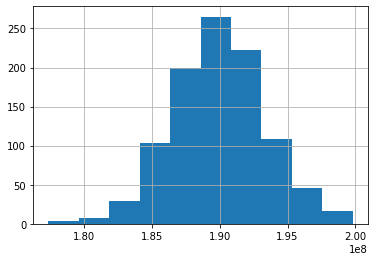

In [9]:
values0.hist()
plt.show()
values1.hist()
plt.show()
values2.hist()

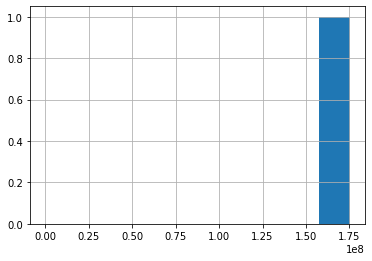

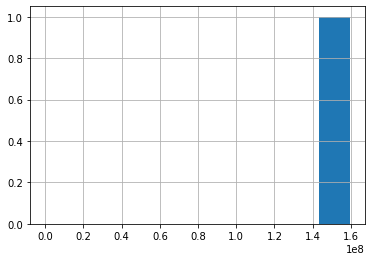

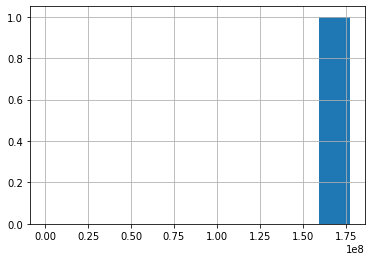

In [10]:
values0.hist(range=(0,values0.min()))
plt.show()
values1.hist(range=(0,values1.min()))
plt.show()
values2.hist(range=(0,values2.min()))

В окрестностях 0 нет значений ни по одному региону - риски отсутствуют. По условиям задачи нуно выбрать регион с наибольшей средней прибылью. Это регион гео2.